In [106]:
from ultralytics import YOLO
from PIL import Image
from matplotlib import pyplot as plt
import math
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
from time import time
# Load a model
vehicle_model = YOLO("yolov8x.pt")  # load a pretrained model (recommended for training)
beacon_model = YOLO("runs\\detect\\train6\\weights\\best.pt")

In [2]:
img_name = image_name
vehicle_results = vehicle_model(img_name, verbose=False, classes=[7,2])

#img = Image.open(img_name)
img = Image.open(img_name)

v_results_array = vehicle_results[0].boxes
vehicle_list = []

for i in v_results_array:
    current_box = i.boxes[0]
    class_tensor = current_box[5]
    x1 = int(current_box[0])
    y1 = int(current_box[1]) - 70
    x2 = int(current_box[2])
    y2 = int(current_box[3])
    img_result = img.crop((x1,y1,x2,y2))
    vehicle_list.append(img_result)

beacon_r = beacon_model(vehicle_list[5], verbose=True, show=True)

NameError: name 'image_name' is not defined

In [117]:
beacon_list = []
classes = []
def find_beacon(image_name):
    f1 = int(time() * 1000)
    img_name = image_name
    vehicle_results = vehicle_model(img_name, verbose=False, classes=[7,2])

    #img = Image.open(img_name)
    img = Image.open(img_name)
    
    print("Image width:", img.width)
    print("Image height:", img.height)

    v_results_array = vehicle_results[0].boxes
    vehicle_list = []

    for i in v_results_array:
        current_box = i.boxes[0]
        class_tensor = current_box[5]
        x1 = int(current_box[0])
        y1 = int(current_box[1]) - 70
        x2 = int(current_box[2])
        y2 = int(current_box[3])
        print("Vehicle loc:", x1,y1,x2,y2)
        img_result = img.crop((x1,y1,x2,y2))
        vehicle_list.append(img_result)

    fig = plt.figure(figsize=(15, 7))
    columns = 5
    rows = math.ceil(len(vehicle_list)/columns)

    %matplotlib inline
    for i, n in enumerate(vehicle_list):
        fig.add_subplot(rows, columns, (i+1))
        plt.imshow(np.squeeze(n))

    if vehicle_list:
        for i,v in enumerate(vehicle_list):
            beacon_result = beacon_model(v, verbose=False)

            b_result_array = beacon_result[0].boxes
            smallest_width = 1000
            smallest_width_pos = 0
            long_beacon_count = 0
            firetruck_bwidth = []
            firetruck_bheight = []
            for a,b in enumerate(b_result_array):
                current_box = b.boxes[0]
                class_tensor = current_box[5]
                x1 = int(current_box[0])
                y1 = int(current_box[1])
                x2 = int(current_box[2])
                y2 = int(current_box[3])
                print("Beacon loc:",x1,y1,x2,y2)
                print(i, class_tensor)
                if class_tensor == 4.:
                    bheight = y2-y1
                    bwidth = x2-x1
                    print(bheight)
                    print(bwidth)
                    if bheight > 5 and bwidth > 50 and bwidth < 500 and (bwidth/bheight) > 5.2:
                        long_beacon_count += 1
                        if bwidth < smallest_width:
                            smallest_width = x2-x1
                            smallest_width_pos = len(beacon_list)-1
                        if bheight < 15:
                            y2 += 15-bheight
                        img_result = v.crop((x1,y1,x2,y2))
                        beacon_list.append(img_result)
                        classes.append(class_tensor)
                elif class_tensor == 2.:
                    x1 -= 2
                    y1 -= 1
                    x2 += 2
                    y2 += 5
                    firetruck_bwidth.append([x2,x1])
                    firetruck_bheight.append([y2,y1])
                    img_result = v.crop((x1,y1,x2,y2))
                    beacon_list.append(img_result)
                    classes.append(class_tensor)
                    if a == 1:
                        break
                else:
                    img_result = v.crop((x1,y1,x2,y2))
                    beacon_list.append(img_result)
                    classes.append(class_tensor)
            if long_beacon_count > 1:
                del beacon_list[smallest_width_pos]
                del classes[smallest_width_pos]
            elif len(firetruck_bwidth) > 1:
                which_bwidth = 0
                which_bheight = 0
                width_dif = (firetruck_bwidth[0][0]-firetruck_bwidth[0][1])-(firetruck_bwidth[1][0]-firetruck_bwidth[1][1])
                height_dif = (firetruck_bheight[0][0]-firetruck_bheight[0][1])-(firetruck_bheight[1][0]-firetruck_bheight[1][1])
                left_changes = abs(int(width_dif*3/4))
                right_changes = abs(width_dif) - left_changes
                bottom_changes = abs(height_dif)
                if width_dif < 0:
                    which_bwidth = 1
                if height_dif < 0:
                    which_bheight = 1
                if left_changes != 0 or right_changes != 0:
                    new_x1 = firetruck_bwidth[which_bwidth][1]+left_changes
                    new_x2 = firetruck_bwidth[which_bwidth][0]-right_changes
                    same_y1 = firetruck_bheight[which_bwidth][1]
                    same_y2 = firetruck_bheight[which_bwidth][0]
                    beacon_list[len(beacon_list)-1-(1-which_bwidth)] = v.crop((new_x1,same_y1,new_x2,same_y2))
                if bottom_changes != 0:
                    same_x1 = firetruck_bwidth[which_bheight][1]+left_changes
                    same_x2 = firetruck_bwidth[which_bheight][0]-right_changes
                    same_y1 = firetruck_bheight[which_bheight][1]
                    new_y2 = firetruck_bheight[which_bheight][0]-bottom_changes
                    beacon_list[len(beacon_list)-1-(1-which_bheight)] = v.crop((same_x1,same_y1,same_x2,new_y2))

        fig = plt.figure(figsize=(15, 7))
        columns = 6
        rows = math.ceil(len(vehicle_list)/columns)

        %matplotlib inline
        for i, b in enumerate(beacon_list):
            fig.add_subplot(rows, columns, (i+1))
            plt.imshow(b)
    print("Time took:",int(time() * 1000) - f1)

def find_bright_area(beacon_num):
    current_loc = beacon_num
    image = np.squeeze(beacon_list[current_loc])
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = gaussian_filter(gray_image, sigma=3)

    [minVal, maxVal, minLoc, maxLoc] = cv2.minMaxLoc(blurred_image)
    thresh = int(maxVal * 0.7)
    if classes[current_loc] == 1. or classes[current_loc] == 2.:
        thresh = int(maxVal * 0.9)
    elif classes[current_loc] == 0.:
        thresh = int(maxVal * 0.8)
    ret, thresh_img = cv2.threshold(blurred_image, thresh, 255, cv2.THRESH_BINARY)
    print("Max value : ", maxVal)
    print("Threshold value: ", thresh)

    # cv2.imshow('something', thresh_img)
    # cv2.imshow('another', image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    print("Number of Contours found = " + str(len(contours)))
    cv2.drawContours(blurred_image, contours, -1, (0, 255, 0), 3)
    width = int(Image.fromarray(image, 'RGB').width*3)
    height = int(Image.fromarray(image, 'RGB').height*3)
    resize_img = cv2.resize(blurred_image, dsize=(width, height), interpolation=cv2.INTER_CUBIC)
    cv2.imshow('Contours', resize_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
def filter_bright_area(beacon_num):
    f1 = int(time() * 1000)
    mid_contour_count = 0
    current_loc = beacon_num
    data = beacon_list[beacon_num]
    pil_image = data
    height_half_point = int(pil_image.height/2)
    width_half_point = int(pil_image.width/2)
    image_height = pil_image.height
    image_width = pil_image.width
    quarter_x = int(image_width/4)
    quarter34_x = image_width-quarter_x
    one_third = int(image_width/3)
    two_third = image_width-one_third

    print("Half point y: ",height_half_point)
    print("Height: ",pil_image.height)
    print("Width: ", image_width)
    print("Half point x: ",width_half_point)
    print("Quarter34 x: ", quarter34_x)
    print("Classes: ", classes[current_loc])

    gray_image = cv2.cvtColor(np.asarray(pil_image), cv2.COLOR_BGR2GRAY)
    blurred_image = gaussian_filter(gray_image, sigma=3)
    [minVal, maxVal, minLoc, maxLoc] = cv2.minMaxLoc(blurred_image)
    thresh = int(maxVal * 0.7)
    if classes[current_loc] == 1. or classes[current_loc] == 2.:
        thresh = int(maxVal * 0.9)
    elif classes[current_loc] == 0.:
        thresh = int(maxVal * 0.8)
    if thresh < 100:
        return 0
    ret, thresh_img = cv2.threshold(blurred_image, thresh, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    print("Number of Contours found = " + str(len(contours)))
    
    for cnt_count, cnt in enumerate(contours):
        reach_half_y = False
        reach_edge_x = False
        reach_edge_y = False
        reach_half_x = False
        reach_near_edge_x_count = 0
        reach_quarter_x = False
        reach_quarter34_x = False
        reach_quarter_x_half_y = False
        reach_quarter34_x_half_y = False
        reach_edge_y_bottom = False
        reach_eighth_x = False
        reach_middle_third_count = 0
        reach_edge_y_top = False
        lowest_y = 5000
        highest_y = 0
        lowest_x = 5000
        highest_x = 0
        firetruck_lowest_loc = [0,5000] #x,y
        firetruck_highest_loc = [0,0] #x,y
        for i in cnt:
            print(i)
            if classes[current_loc] == 4.:
                if i[0][1] > highest_y:
                    highest_y = i[0][1]
                if i[0][1] < lowest_y:
                    lowest_y = i[0][1]
                if i[0][0] >= one_third and i[0][0] <= two_third:
                    reach_middle_third_count += 1
                else:
                    reach_middle_third_count -= 1
                if i[0][1] >= height_half_point and i[0][1] < height_half_point+5:
                    reach_half_y = True
                if i[0][0] >= width_half_point-1 and i[0][0] <= width_half_point+1:
                    reach_half_x = True
                if i[0][0] >= quarter_x-1 and i[0][0] <= quarter_x+1:
                    reach_quarter_x = True
                    if i[0][1] >= height_half_point and i[0][1] < image_height:
                        reach_quarter_x_half_y = True
                if i[0][0] >= quarter34_x-1 and i[0][0] <= quarter34_x+1:
                    reach_quarter34_x = True
                    if i[0][1] >= height_half_point and i[0][1] < image_height:
                        reach_quarter34_x_half_y = True
                if i[0][0] < quarter_x-1 or i[0][0] > quarter34_x+1:
                    reach_near_edge_x_count += 1
                else:
                    reach_near_edge_x_count -= 1
                if (i[0][1] >= 0 and i[0][1] < 5) or (i[0][1] > image_height-5 and i[0][1] <= image_height):
                    reach_edge_y = True
                    if i[0][1] > image_height-5 and i[0][1] <= image_height:
                        reach_edge_y_bottom = True
                if (i[0][0] >= 0 and i[0][0] < 5) or (i[0][0] > image_width-5 and i[0][0] <= image_width):
                    reach_edge_x = True
            elif classes[current_loc] == 2. or classes[current_loc] == 0.:
                if i[0][1] > highest_y:
                    highest_y = i[0][1]
                if i[0][1] < lowest_y:
                    lowest_y = i[0][1]
                if i[0][0] > highest_x:
                    highest_x = i[0][0]
                if i[0][0] < lowest_x:
                    lowest_x = i[0][0]
                if i[0][1] <= 3 or i[0][1] >= image_height-3:
                    reach_edge_y = True
                if i[0][0] <= 3 or i[0][0] >= image_width-3:
                    reach_edge_x = True
                if i[0][0] >= width_half_point-1 and i[0][0] <= width_half_point+1:
                    reach_half_x = True
                if i[0][1] >= height_half_point-1 and i[0][1] < height_half_point+1:
                    reach_half_y = True
            else:
                if i[0][1] >= height_half_point-2 and i[0][1] < height_half_point+2:
                    reach_half_y = True
                if i[0][1] < 5 or i[0][1] > image_height-5 or i[0][0] < 5 or i[0][0] > image_width-5:
                    reach_edge_y = True
                if i[0][0] >= width_half_point-1 and i[0][0] <= width_half_point+1:
                    reach_half_x = True
                if (i[0][0] >= quarter_x-1 and i[0][0] <= quarter_x+1) or (i[0][0] >= quarter34_x-1 and i[0][0] <= quarter34_x+1):
                    reach_quarter_x = True            
        if classes[current_loc] == 4.:
            if ((reach_quarter_x_half_y and not reach_quarter34_x) or (reach_quarter34_x_half_y and not reach_quarter_x)) and reach_half_x and not reach_edge_x and not reach_edge_y_bottom and (highest_y-lowest_y)/height_half_point > 0.9: 
                cv2.drawContours(blurred_image, cnt, -1, (0, 255, 0), 3)
                mid_contour_count += 1
                print(0)
            if reach_half_y and (reach_quarter_x or reach_quarter34_x) and not reach_half_x and not (reach_edge_x or reach_edge_y) and (highest_y-lowest_y)/height_half_point > 0.9:
                cv2.drawContours(blurred_image, cnt, -1, (0, 255, 0), 3)
                mid_contour_count += 1
                print(1)
            elif reach_quarter_x_half_y and reach_quarter34_x_half_y and reach_half_x and not reach_edge_x and not reach_edge_y_bottom and (highest_y-lowest_y)/height_half_point > 1.0:
                cv2.drawContours(blurred_image, cnt, -1, (0, 255, 0), 3)
                mid_contour_count += 1
                print(2)
            elif reach_half_y and reach_near_edge_x_count > 5 and not reach_half_x and not reach_edge_x and not reach_edge_y_bottom and (highest_y-lowest_y)/height_half_point > 0.9:
                cv2.drawContours(blurred_image, cnt, -1, (0, 255, 0), 3)
                mid_contour_count += 1
                print(3)
            elif reach_half_y and (reach_quarter_x or reach_quarter34_x) and not reach_half_x and not reach_edge_x and not reach_edge_y_bottom and (highest_y-lowest_y)/height_half_point > 0.9:
                mid_contour_count += 1
                cv2.drawContours(blurred_image, cnt, -1, (0, 255, 0), 3)
                print(4)
            elif reach_half_y and (reach_middle_third_count < -10) and not reach_half_x and not(reach_edge_x or reach_edge_y) and reach_near_edge_x_count < -10:
                mid_contour_count += 1
                cv2.drawContours(blurred_image, cnt, -1, (0, 255, 0), 3)
                print(5)
            elif reach_half_y and (reach_middle_third_count < 0) and not reach_half_x and not(reach_edge_x or reach_edge_y) and (highest_y-lowest_y)/height_half_point > 0.3:
                mid_contour_count += 1
                cv2.drawContours(blurred_image, cnt, -1, (0, 255, 0), 3)
                print(6)
            elif (reach_middle_third_count < 0) and not reach_half_x and not(reach_edge_x or reach_edge_y) and image_height <= 20:
                mid_contour_count += 1
                cv2.drawContours(blurred_image, cnt, -1, (0, 255, 0), 3)
                print(7)
            elif reach_half_y and not reach_half_x and not(reach_edge_x or reach_edge_y) and image_height <= 20:
                mid_contour_count += 1
                cv2.drawContours(blurred_image, cnt, -1, (0, 255, 0), 3)
                print(8)
            elif (reach_quarter_x_half_y or reach_quarter34_x_half_y) and not reach_half_x and not reach_edge_y and (highest_y-lowest_y)/height_half_point > 1.0:
                mid_contour_count += 1
                cv2.drawContours(blurred_image, cnt, -1, (0, 255, 0), 3)
                print(9)
            elif reach_half_y and ((reach_quarter_x and not reach_quarter34_x) or (not reach_quarter_x and reach_quarter34_x)) and not reach_half_x and not reach_edge_x and (highest_y-lowest_y)/height_half_point > 1.0:
                mid_contour_count += 1
                cv2.drawContours(blurred_image, cnt, -1, (0, 255, 0), 3)
                print(10)
        elif classes[current_loc] == 0.:
            if reach_half_x and reach_half_y and not (reach_edge_x or reach_edge_y) and (highest_y-lowest_y)/height_half_point > 0.35 and (highest_x-lowest_x) > (highest_y-lowest_y):
                cv2.drawContours(blurred_image, cnt, -1, (0, 255, 0), 3)
                mid_contour_count += 1
                print(11)
        elif classes[current_loc] == 2.:
            if reach_half_x and reach_half_y and not (reach_edge_x or reach_edge_y) and ((highest_y-lowest_y)/height_half_point > 0.54 or (highest_y-lowest_y) >= (highest_x-lowest_x)):
                cv2.drawContours(blurred_image, cnt, -1, (0, 255, 0), 3)
                mid_contour_count += 1
                print(12)
        elif classes[current_loc] == 3.:
            if reach_half_x and not (reach_edge_x or reach_edge_y):
                cv2.drawContours(blurred_image, cnt, -1, (0, 255, 0), 3)
                mid_contour_count += 1
                print(13)
            elif reach_quarter_x and reach_half_y and not (reach_edge_x or reach_edge_y):
                cv2.drawContours(blurred_image, cnt, -1, (0, 255, 0), 3)
                mid_contour_count += 1
                print(14)
        else:
            if reach_half_x and reach_half_y and not (reach_edge_x or reach_edge_y):
                cv2.drawContours(blurred_image, cnt, -1, (0, 255, 0), 3)
                mid_contour_count += 1
                print(15)

        print("Contour Max height:", (highest_y-lowest_y))
        print("Contour Max width: ", (highest_x-lowest_x))
        print("highest y: ", highest_y)
        print("Half y:", reach_half_y)
        print("Edge x:", reach_edge_x)
        print("Edge y:", reach_edge_y)
        print("Half x: ", reach_half_x)
        print("Quarter x: ",reach_quarter_x)
        print("Quarter 34 x: ", reach_quarter34_x)
        print("Quarter x half y: ", reach_quarter_x_half_y)
        print("Quarter34 half y: ", reach_quarter34_x_half_y)
        print("Y bottom: ", reach_edge_y_bottom)
        print("Reach near edge x count: ", reach_near_edge_x_count)
        print("Middle third count: ", reach_middle_third_count)
        print("next")
        print("Contour length: ", len(cnt))
        print()

    print("Lit point found: ",mid_contour_count)
    print("Time took: ",int(time() * 1000) - f1)
    width = pil_image.width*3
    height = pil_image.height*3
    resize_img = cv2.resize(blurred_image, dsize=(width, height), interpolation=cv2.INTER_CUBIC)
    cv2.imshow('Contours', resize_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [104]:
current_loc = 0
image = np.squeeze(beacon_list[current_loc])
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred_image = gaussian_filter(gray_image, sigma=3)

[minVal, maxVal, minLoc, maxLoc] = cv2.minMaxLoc(blurred_image)
thresh = int(maxVal * 0.7)
if classes[current_loc] == 1. or classes[current_loc] == 2.:
    thresh = int(maxVal * 0.9)
elif classes[current_loc] == 0.:
    thresh = int(maxVal * 0.8)
ret, thresh_img = cv2.threshold(blurred_image, thresh, 255, cv2.THRESH_BINARY)
print("Max value : ", maxVal)
print("Threshold value: ", thresh)

# cv2.imshow('something', thresh_img)
# cv2.imshow('another', image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print("Number of Contours found = " + str(len(contours)))
cv2.drawContours(blurred_image, contours[1], -1, (0, 255, 0), 3)
width = int(Image.fromarray(image, 'RGB').width*3)
height = int(Image.fromarray(image, 'RGB').height*3)
resize_img = cv2.resize(blurred_image, dsize=(width, height), interpolation=cv2.INTER_CUBIC)
cv2.imshow('Contours', resize_img)
cv2.waitKey(0)
cv2.destroyAllWindows()
temp_cont = contours[0]

Max value :  197.0
Threshold value:  137
Number of Contours found = 3


In [65]:
test_img = Image.fromarray(gray_image)
print(test_img)
sum = 0
for c in temp_cont:
    sum += test_img.getpixel((c[0][0], c[0][1]))
print(sum/len(temp_cont))

<PIL.Image.Image image mode=L size=74x15 at 0x20FDC1767C0>
222.66666666666666


Image width: 1080
Image height: 1920
Vehicle loc: 31 498 798 1449
Vehicle loc: 771 845 1071 1136
Beacon loc: 503 140 636 211
0 tensor(3., device='cuda:0')
Time took: 612


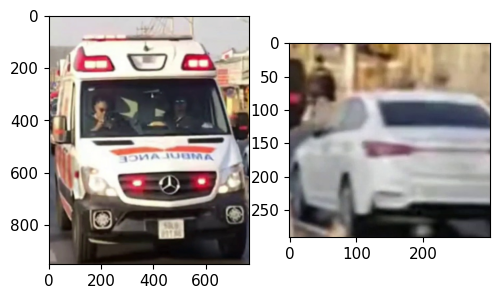

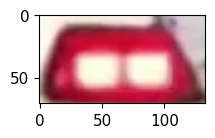

In [118]:
beacon_list = []
classes = []
image_name = "videoImages/frame98.jpg"
find_beacon(image_name)

In [113]:
beacon_num = 0
find_bright_area(beacon_num)

Max value :  247.0
Threshold value:  172
Number of Contours found = 4


In [102]:
filter_bright_area(beacon_num)

Half point y:  7
Height:  15
Width:  86
Half point x:  43
Quarter34 x:  65
Classes:  tensor(4., device='cuda:0')
Number of Contours found = 3
[[71 14]]
[[72 14]]
Contour Max height: 0
Contour Max width:  -5000
highest y:  14
Half y: False
Edge x: False
Edge y: True
Half x:  False
Quarter x:  False
Quarter 34 x:  False
Quarter x half y:  False
Quarter34 half y:  False
Y bottom:  True
Reach near edge x count:  2
Middle third count:  -2
next
Contour length:  2

[[8 4]]
[[7 5]]
[[7 6]]
[[8 7]]
[[9 7]]
[[10  7]]
[[10  6]]
[[10  5]]
[[9 4]]
Contour Max height: 3
Contour Max width:  -5000
highest y:  7
Half y: True
Edge x: False
Edge y: True
Half x:  False
Quarter x:  False
Quarter 34 x:  False
Quarter x half y:  False
Quarter34 half y:  False
Y bottom:  False
Reach near edge x count:  9
Middle third count:  -9
next
Contour length:  9

[[51  0]]
[[52  1]]
[[53  2]]
[[54  2]]
[[55  3]]
[[56  3]]
[[57  3]]
[[58  3]]
[[59  3]]
[[60  3]]
[[61  3]]
[[62  3]]
[[63  3]]
[[64  3]]
[[65  3]]
[[66  2]]

In [89]:
#blurred_image = cv2.line(blurred_image, (one_third, 0), (one_third, image_height), (255, 0, 0), 1)
#blurred_image = cv2.line(blurred_image, (two_third, 0), (one_third, image_height), (255,0,0),1)

width = int(Image.fromarray(image, 'RGB').width*3)
height = int(Image.fromarray(image, 'RGB').height*3)
resize_img = cv2.resize(image, dsize=(width, height), interpolation=cv2.INTER_CUBIC)
resize_img = cv2.cvtColor(np.asarray(resize_img), cv2.COLOR_RGB2BGR)
cv2.imshow('Contours', resize_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [1]:
from ultralytics import YOLO

In [2]:
model = YOLO('yolov8x.pt')  # load a pretrained model (recommended for training)
# Train the model
model.train(data='data.yaml', batch=8, epochs=500, imgsz=640)

New https://pypi.org/project/ultralytics/8.0.121 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.62  Python-3.9.13 torch-2.0.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)
yolo\engine\trainer: task=detect, mode=train, model=yolov8x.pt, data=data.yaml, epochs=500, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=Non

Time took: 6863


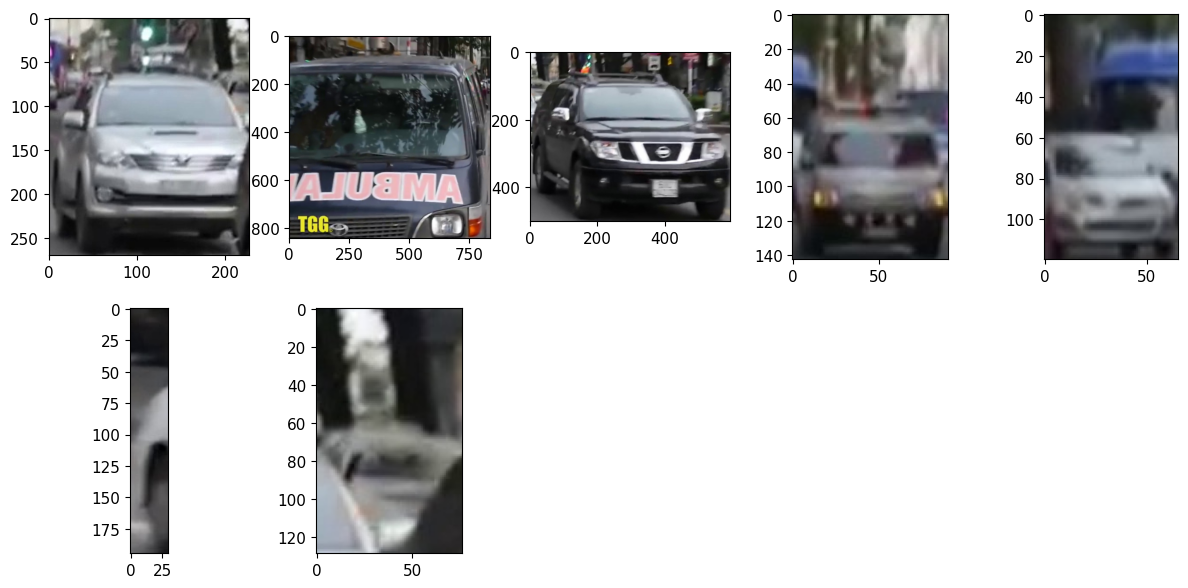

<Figure size 1500x700 with 0 Axes>

In [2]:
f1 = int(time() * 1000)
img_name = "videoImages/frame3.jpg"

vehicle_results = vehicle_model(img_name, verbose=False, classes=[7,2])

#img = Image.open(img_name)
img = Image.open(img_name)

v_results_array = vehicle_results[0].boxes
vehicle_list = []

for i in v_results_array:
    current_box = i.boxes[0]
    class_tensor = current_box[5]
    x1 = int(current_box[0])
    y1 = int(current_box[1]) - 60
    x2 = int(current_box[2])
    y2 = int(current_box[3])
    img_result = img.crop((x1,y1,x2,y2))
    vehicle_list.append(img_result)

fig = plt.figure(figsize=(15, 7))
columns = 5
rows = math.ceil(len(vehicle_list)/columns)

%matplotlib inline
for i, n in enumerate(vehicle_list):
    fig.add_subplot(rows, columns, (i+1))
    plt.imshow(np.squeeze(n))

if vehicle_list:
    beacon_list = []
    classes = []
    for i,v in enumerate(vehicle_list):
        beacon_result = beacon_model(v, verbose=False)

        b_result_array = beacon_result[0].boxes
        smallest_width = 1000
        smallest_width_pos = 0
        long_beacon_count = 0
        firetruck_bwidth = []
        firetruck_bheight = []
        for a,b in enumerate(b_result_array):
            current_box = b.boxes[0]
            class_tensor = current_box[5]
            x1 = int(current_box[0])
            y1 = int(current_box[1])
            x2 = int(current_box[2])
            y2 = int(current_box[3])
            print(i, class_tensor)
            if class_tensor == 4.:
                bheight = y2-y1
                bwidth = x2-x1
                print(bheight)
                print(bwidth)
                if bheight > 5 and bwidth > 50 and bwidth < 500 and (bwidth/bheight) > 4.78:
                    long_beacon_count += 1
                    if bwidth < smallest_width:
                        smallest_width = x2-x1
                        smallest_width_pos = a
                    if bheight < 15:
                        y2 += 15-bheight
                    img_result = v.crop((x1,y1,x2,y2))
                    beacon_list.append(img_result)
                    classes.append(class_tensor)
            elif class_tensor == 2.:
                x1 -= 2
                y1 -= 1
                x2 += 2
                y2 += 5
                firetruck_bwidth.append([x2,x1])
                firetruck_bheight.append([y2,y1])
                img_result = v.crop((x1,y1,x2,y2))
                beacon_list.append(img_result)
                classes.append(class_tensor)
                if a == 1:
                    break
            else:
                img_result = v.crop((x1,y1,x2,y2))
                beacon_list.append(img_result)
                classes.append(class_tensor)
        if long_beacon_count > 1:
            del beacon_list[smallest_width_pos]
            del classes[smallest_width_pos]
        elif len(firetruck_bwidth) > 1:
            which_bwidth = 0
            which_bheight = 0
            width_dif = (firetruck_bwidth[0][0]-firetruck_bwidth[0][1])-(firetruck_bwidth[1][0]-firetruck_bwidth[1][1])
            height_dif = (firetruck_bheight[0][0]-firetruck_bheight[0][1])-(firetruck_bheight[1][0]-firetruck_bheight[1][1])
            left_changes = abs(int(width_dif*3/4))
            right_changes = abs(width_dif) - left_changes
            bottom_changes = abs(height_dif)
            if width_dif < 0:
                which_bwidth = 1
            if height_dif < 0:
                which_bheight = 1
            if left_changes != 0 or right_changes != 0:
                new_x1 = firetruck_bwidth[which_bwidth][1]+left_changes
                new_x2 = firetruck_bwidth[which_bwidth][0]-right_changes
                same_y1 = firetruck_bheight[which_bwidth][1]
                same_y2 = firetruck_bheight[which_bwidth][0]
                beacon_list[len(beacon_list)-1-(1-which_bwidth)] = v.crop((new_x1,same_y1,new_x2,same_y2))
            if bottom_changes != 0:
                same_x1 = firetruck_bwidth[which_bheight][1]+left_changes
                same_x2 = firetruck_bwidth[which_bheight][0]-right_changes
                same_y1 = firetruck_bheight[which_bheight][1]
                new_y2 = firetruck_bheight[which_bheight][0]-bottom_changes
                beacon_list[len(beacon_list)-1-(1-which_bheight)] = v.crop((same_x1,same_y1,same_x2,new_y2))
            
    fig = plt.figure(figsize=(15, 7))
    columns = 6
    rows = math.ceil(len(vehicle_list)/columns)

    %matplotlib inline
    for i, b in enumerate(beacon_list):
        fig.add_subplot(rows, columns, (i+1))
        plt.imshow(b)
print("Time took:",int(time() * 1000) - f1)

In [7]:
#blurred_image = cv2.line(blurred_image, (one_third, 0), (one_third, image_height), (255, 0, 0), 1)
#blurred_image = cv2.line(blurred_image, (two_third, 0), (one_third, image_height), (255,0,0),1)

img = cv2.imread("C:/Users/minhc/Personal Docs/Works/Final Project/light bar types/type (1).jpg", cv2.IMREAD_COLOR)

width = 220
height = 80
resize_img = cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_CUBIC)
#resize_img = cv2.cvtColor(np.asarray(resize_img), cv2.COLOR_RGB2BGR)


img_name = 'C:/Users/minhc/Personal Docs/Works/Final Project/light bar types/12.png'  
cv2.imwrite(img_name, resize_img)

# cv2.imshow('Contours', resize_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

True